# Customer Lifetime Value (CLV) prediction

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [19]:
#You can use a simulated dataset or a real-world e-commerce dataset that includes customer transactions. 
#In this example, I'll generate a synthetic dataset for illustration purposes.
np.random.seed(42)

n_customers = 500
start_date = datetime(2019, 1, 1)
end_date = datetime(2021, 12, 31)

customer_ids = np.arange(1, n_customers + 1)
purchase_dates = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days)) for _ in range(1000)]
purchase_amounts = np.random.uniform(10, 100, 1000)

df = pd.DataFrame({'CustomerID': np.random.choice(customer_ids, 1000),
                   'PurchaseDate': purchase_dates,
                   'PurchaseAmount': purchase_amounts})

# Save the dataset to a CSV file
df.to_csv('clv_dataset.csv', index=False)

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

     CustomerID PurchaseDate  PurchaseAmount
0           109   2021-05-10       59.876020
1            76   2021-11-10       68.627835
2            30   2019-05-02       84.676762
3           314   2020-04-11       28.577914
4           486   2019-11-27       10.989625
5           117   2019-03-29       22.319707
6           415   2021-05-21       91.001678
7           356   2019-05-11       88.650107
8           192   2021-02-08       63.767179
9            19   2019-12-10       64.046517
10          432   2021-03-16       69.853301
11          173   2020-01-21       25.783415
12          228   2021-08-13       92.297075
13          350   2019-10-04       47.689347
14          183   2020-04-04       44.482468
15          113   2019-01-22       56.702593
16          183   2019-09-10       14.226937
17          481   2021-01-17       24.965503
18          146   2021-05-06       76.423025
19          319   2020-04-19       17.451880
20          116   2021-12-18       64.283690
21        

In [21]:
import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [22]:
# Load the dataset
df = pd.read_csv('clv_dataset.csv')
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

In [23]:
df.head()

,CustomerID,PurchaseDate,PurchaseAmount
0,109,2021-05-10,59.876020
1,76,2021-11-10,68.627835
2,30,2019-05-02,84.676762
3,314,2020-04-11,28.577914
4,486,2019-11-27,10.989625


In [24]:
# Convert data to the format required by the lifetimes library
data = summary_data_from_transaction_data(df, 'CustomerID', 'PurchaseDate', monetary_value_col='PurchaseAmount', observation_period_end='2021-12-31')

In [25]:
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
1,1.0,1021.0,1067.0,89.017689
2,2.0,534.0,942.0,45.529170
4,0.0,0.0,220.0,0.000000
5,0.0,0.0,39.0,0.000000
7,1.0,508.0,749.0,99.205176


In [26]:
# Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 424 subjects, a: 0.00, alpha: 6845.43, b: 52035.56, r: 12.99>

In [27]:
# Predict future transactions for the next 365 days
t = 365
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])

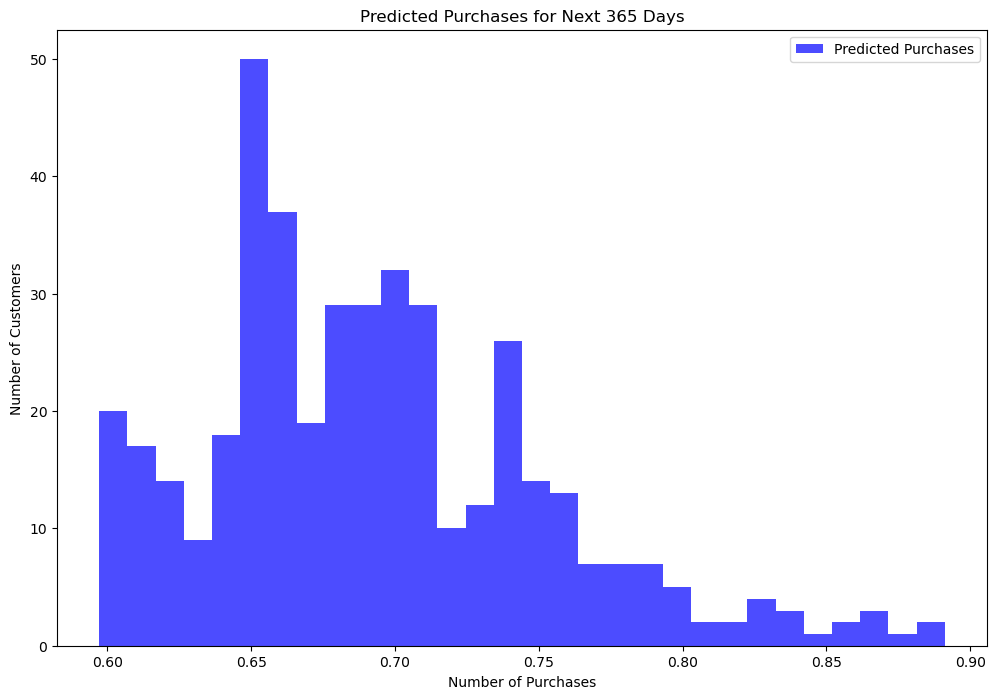

In [28]:
# Visualize the predicted purchases
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.hist(data['predicted_purchases'], bins=30, alpha=0.7, color='b', label='Predicted Purchases')
plt.title('Predicted Purchases for Next 365 Days')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error

# Assuming you have predictions stored in the 'predicted_purchases' column
predictions = data['predicted_purchases']

# Assuming you have the true values of purchases (ground truth) in the 'frequency' column
true_values = data['frequency']

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, predictions)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.137749618255572


In [30]:
from sklearn.metrics import r2_score

# Assuming you have predictions and true values as before
predictions = data['predicted_purchases']
true_values = data['frequency']

# Calculate R-squared
r_squared = r2_score(true_values, predictions)

print(f'R-squared: {r_squared:.2f}')

R-squared: -0.17


Interpretation of R-squared:

    R-squared of 1.0: The model perfectly predicts the target variable.
    R-squared close to 0: The model does not explain much of the variance in the target variable.
    Negative R-squared: The model is worse than a simple mean.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [36]:
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
df.head()

,CustomerID,PurchaseDate,PurchaseAmount,Recency,Frequency,MonetaryValue
0,109,2021-05-10,59.876020,929,6,59.876020
1,76,2021-11-10,68.627835,745,5,68.627835
2,30,2019-05-02,84.676762,1668,4,84.676762
3,314,2020-04-11,28.577914,1323,3,28.577914
4,486,2019-11-27,10.989625,1459,6,10.989625


In [38]:
# Feature Engineering
df['Recency'] = (pd.to_datetime('now') - df['PurchaseDate']).dt.days
df['Frequency'] = df.groupby('CustomerID')['PurchaseDate'].transform('count')
df['MonetaryValue'] = df['PurchaseAmount']

In [39]:
# Select features and target variable
X = df[['Recency', 'Frequency', 'MonetaryValue']]
y = df['Frequency']  # Change to 'MonetaryValue' if predicting CLV

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [43]:
print(y_test)
print(y_pred)

521    4
737    4
740    4
660    6
411    4
      ..
408    2
332    3
208    2
613    3
78     2
Name: Frequency, Length: 200, dtype: int64
[4. 4. 4. 6. 4. 1. 6. 2. 3. 4. 3. 3. 3. 3. 4. 4. 1. 4. 3. 1. 4. 3. 3. 2.
 5. 4. 2. 4. 1. 5. 2. 3. 2. 3. 1. 4. 6. 3. 6. 4. 1. 2. 1. 2. 4. 5. 5. 3.
 1. 2. 4. 1. 3. 2. 7. 4. 6. 6. 2. 3. 6. 2. 1. 3. 1. 4. 3. 4. 1. 2. 1. 1.
 1. 2. 3. 2. 3. 4. 2. 3. 2. 3. 4. 4. 6. 2. 3. 5. 4. 4. 7. 5. 4. 3. 1. 3.
 3. 2. 4. 4. 4. 4. 4. 5. 1. 1. 2. 5. 2. 5. 1. 1. 1. 3. 3. 2. 1. 5. 1. 5.
 2. 3. 4. 3. 4. 2. 5. 7. 3. 3. 4. 2. 2. 2. 3. 4. 3. 2. 2. 3. 2. 4. 5. 3.
 2. 2. 5. 2. 5. 2. 3. 6. 3. 2. 2. 2. 4. 3. 2. 4. 2. 5. 3. 1. 5. 1. 4. 2.
 3. 6. 6. 3. 4. 3. 1. 2. 3. 1. 3. 6. 4. 3. 5. 2. 3. 5. 6. 4. 4. 4. 3. 5.
 2. 4. 3. 2. 3. 2. 3. 2.]


In [44]:
# Evaluate the model using R-squared
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared:.2f}')

R-squared: 1.00


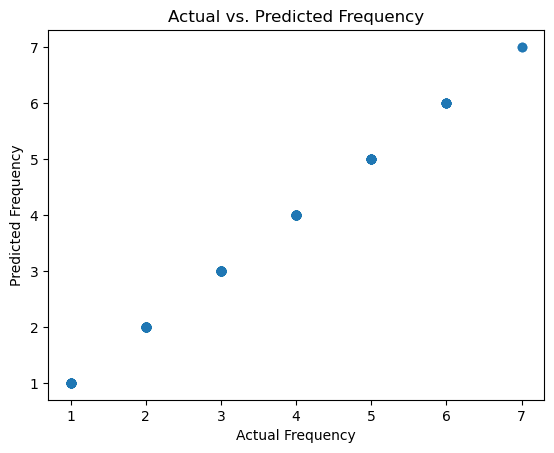

In [45]:
# Visualize actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Frequency')
plt.ylabel('Predicted Frequency')
plt.title('Actual vs. Predicted Frequency')
plt.show()

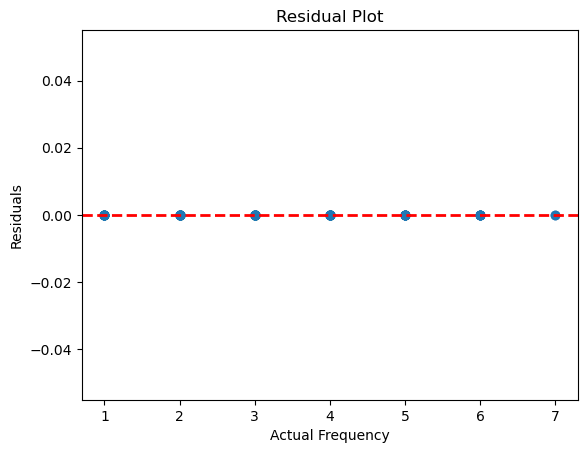

In [46]:
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Horizontal line at y=0 for reference
plt.xlabel('Actual Frequency')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()